In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matspy import spy
import json
from pipeliner.recommendations.transformer import (
    UserItemMatrixTransformer,
    SimilarityTransformer,
)
from pipeliner.recommendations.recommender import SimilarityRecommender, UserBasedRecommender


In [55]:
with open("../../tests/test_data/recommendations_toy.json", "r") as f:
    recommendations_toy = json.load(f)

recommendations_toy_probs = np.load("../../tests/test_data/recommendations_toy_probs.npy").astype(np.float32).round(6)

In [56]:
user_item_ratings_df = pd.read_csv(
        "../../tests/test_data/user_item_ratings_toy.csv",
        dtype={"user_id": str, "item_id": str, "rating": np.float32},
        header=0,
    )
print(user_item_ratings_df.shape)
user_item_ratings_df.head(3)

(18, 3)


,user_id,item_id,rating
0,U00001,I00001,1.0
1,U00001,I00002,0.5
2,U00001,I00003,0.5


In [57]:
# encode the user and item ids
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

user_item_ratings_encoded = user_item_ratings_df.copy() 

user_item_ratings_encoded["user_id"] = user_encoder.fit_transform(user_item_ratings_encoded["user_id"])
user_item_ratings_encoded["item_id"] = item_encoder.fit_transform(user_item_ratings_encoded["item_id"])

user_item_ratings = user_item_ratings_encoded.to_numpy().astype(np.float32)

unique_users = pd.Series(user_encoder.classes_)
unique_items = pd.Series(item_encoder.classes_)

print(unique_users.shape[0], unique_items.shape[0])
user_item_ratings_encoded.head(3)

6 6


,user_id,item_id,rating
0,0,0,1.0
1,0,1,0.5
2,0,2,0.5


In [58]:
# fixed datasets with known values for validation

user_item_matrix_toy = pd.read_csv(
        "../../tests/test_data/user_item_matrix_toy.csv",
        header=0,
        index_col=['user_id'],
    ).astype(np.float32)

item_similarity_matrix_toy = pd.read_csv(
    "../../tests/test_data/item_similarity_matrix_toy.csv",
    header=0,
    index_col=["item_id"],
).astype(np.float32)

user_similarity_matrix_toy = pd.read_csv(
    "../../tests/test_data/user_similarity_matrix_toy.csv",
    header=0,
    index_col=["user_id"],
).astype(np.float32)

user_item_matrix_toy

,I00001,I00002,I00003,I00004,I00005,I00006
user_id,,,,,,
U00001,1.0,0.5,0.5,0.0,0.0,0.0
U00002,0.0,1.0,0.5,0.5,0.0,0.0
U00003,0.0,0.0,1.0,0.5,0.5,0.0
U00004,0.0,0.0,0.0,1.0,0.5,0.5
U00005,0.5,0.0,0.0,0.0,1.0,0.5
U00006,0.5,0.5,0.0,0.0,0.0,1.0


In [59]:
user_item_matrix_transformer = UserItemMatrixTransformer()
user_item_matrix = user_item_matrix_transformer.transform(user_item_ratings)

assert user_item_matrix.shape == user_item_matrix_toy.shape
np.testing.assert_array_equal(
    user_item_matrix.toarray(), 
    user_item_matrix_toy.to_numpy(),
)

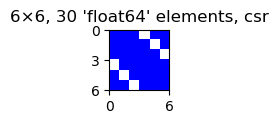

In [60]:
item_similarity_matrix_transformer =  SimilarityTransformer()
item_similarity_matrix = item_similarity_matrix_transformer.transform(user_item_matrix.T)

assert item_similarity_matrix.shape == item_similarity_matrix_toy.shape
np.testing.assert_array_equal(
    item_similarity_matrix.toarray().astype(np.float32).round(6),
    item_similarity_matrix_toy.to_numpy().astype(np.float32).round(6),
)

spy(item_similarity_matrix)

In [61]:
user_similarity_matrix_transformer =  SimilarityTransformer()
user_similarity_matrix = user_similarity_matrix_transformer.transform(user_item_matrix)

assert user_similarity_matrix.shape == user_similarity_matrix_toy.shape
np.testing.assert_array_equal(
    user_similarity_matrix.toarray().astype(np.float32).round(6),
    user_similarity_matrix_toy.to_numpy().astype(np.float32).round(6),
)

In [62]:
item_ids = ['I00001', 'I00002', 'I00003', 'I00004', 'I00005', 'I00006']
item_ids_encoded = item_encoder.transform(item_ids)

item_similarity_matrix_dense = item_similarity_matrix.toarray()

rec = SimilarityRecommender(10)
rec.fit(item_similarity_matrix)
item_recs = rec.predict(item_ids_encoded)

results = [item_encoder.inverse_transform(item).tolist() for item in item_recs]

for item_id, item_id_encoded, result in zip(item_ids, item_ids_encoded, results):
    np.testing.assert_array_equal(recommendations_toy[item_id], result)

item_probs = rec.predict_proba(item_ids_encoded).toarray().astype(np.float32).round(6)
np.testing.assert_array_equal(item_probs, recommendations_toy_probs)

results, item_probs

([['I00002', 'I00006', 'I00003', 'I00005'],
  ['I00001', 'I00003', 'I00004', 'I00006'],
  ['I00002', 'I00004', 'I00001', 'I00005'],
  ['I00003', 'I00005', 'I00002', 'I00006'],
  ['I00004', 'I00006', 'I00001', 'I00003'],
  ['I00001', 'I00005', 'I00002', 'I00004']],
 array([[1.      , 0.5     , 0.333333, 0.      , 0.333333, 0.5     ],
        [0.5     , 1.      , 0.5     , 0.333333, 0.      , 0.333333],
        [0.333333, 0.5     , 1.      , 0.5     , 0.333333, 0.      ],
        [0.      , 0.333333, 0.5     , 1.      , 0.5     , 0.333333],
        [0.333333, 0.      , 0.333333, 0.5     , 1.      , 0.5     ],
        [0.5     , 0.333333, 0.      , 0.333333, 0.5     , 1.      ]],
       dtype=float32))

In [63]:
user_rec = UserBasedRecommender(n=5, n_users=10)
user_rec.fit(user_item_matrix)

item_similarity_matrix_transformer = SimilarityTransformer()
item_similarity_matrix = item_similarity_matrix_transformer.transform(
    user_item_matrix.T
)

user_similarity_matrix.shape, item_similarity_matrix.shape

((6, 6), (6, 6))

In [77]:
# get similar users numpy implementation
user_id = "U00001"
user_id_encoded = user_encoder.transform([user_id])[0]

print(user_id, user_id_encoded)

users_items = user_similarity_matrix[user_id_encoded].toarray() # can't seem to avoid this

user_mask = (users_items > 0) * (np.arange(users_items.size) != user_id_encoded)
sorter = np.argsort(1 - users_items, kind="stable")
sorted_mask = user_mask[0, sorter]
similar_users = sorter[sorted_mask][: 10]

user_mask, sorter, sorted_mask, similar_users, np.argwhere(user_mask[0])

U00001 0


(array([[False,  True,  True, False,  True,  True]]),
 array([[0, 1, 5, 2, 4, 3]]),
 array([[False,  True,  True,  True,  True, False]]),
 array([1, 5, 2, 4]),
 array([[1],
        [2],
        [4],
        [5]]))

In [65]:
# get recommendations for similar users
similar_users_user_item_matrix = user_item_matrix.T[similar_users]

print(similar_users_user_item_matrix.shape)

similar_users_user_item_matrix.toarray()

(4, 6)


array([[0.5, 1. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0.5, 0.5, 1. ],
       [0.5, 0.5, 1. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 1. , 0. ]], dtype=float32)

In [66]:
# get a list of items to exclude (the user has rated these)
exclusions = user_item_matrix[user_id_encoded] > 0
exclusions.toarray()

array([[ True,  True,  True, False, False, False]])